# Ejemplo lo más explicado que pueda con lenguaje súper natural 😅

Primero que todo necesitamos necesitamos datos para encontrar el sistema que los describe.

Para esto vamos a generar los datos de un modelo que ya conocemos para así comparar si el modelo obtenido por el algorítmo coincide con el original, tomaremos el modelo poblacional SIR:

    S’ = - a*I*S
    I’ = a*I*S - b*I
    R’ = b*I

Escribamos una función en python que describa este modelo:

In [1]:
# modelo del SIR
def sir_dx(X, t, a, b):
    S = X[0]
    I = X[1]
    R = X[2]

    return [-a * I * S, a * I * S - b * I, b * I]

Se recibe el tiempo dentro de la función aunque no se utilice porque estamos haciendo este ejemplo para que sea lo más abarcador y genérico posible. Es un ejemplo :D

En este modelo los valores de a y b son parámetros que indican la cantidad de personas que pasan de estar saludables a infectados y de infectados a recuperados, respectivamente. Estos valores también deseamos que sean encontrados por el algorítmo.

Para generar los datos debemos tener un punto inicial, o sea. Un cantidad de saludables, infectados y recuperados iniciales, además debemos conocer cuánto tiempo deseamos en los datos de entrenamiento, además de la cantidad de muestras que se le pasarán al algorítmo.

In [2]:
from sympy.plotting.textplot import linspace
from scipy import integrate
from matplotlib import pyplot as plt

def integrate_sir(time, samples, X0, a, b):
    t = linspace(0, time, samples)

    X, _ = integrate.odeint(sir_dx, X0, t, (a, b), full_output=True)

    S, I, R = X.T

    return (t, S, I, R)

# valores de los parámtros del modelo SIR
a = 0.3
b = 0.4

# punto inicial
X0 = [0.7, 0.3, 0]

# tiempo en el que se generarán los casos de entrenamiento
time = 20

# cantidad de muestras
n = 10000

# datos de entrenamiento
t, S, I, R = integrate_sir(time, n, X0, a, b)

Se muestran los datos para saber que forma visual tienen los datos del modelo

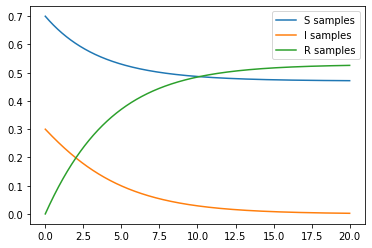

In [3]:
plt.plot(t, S, label="S samples")
plt.plot(t, I, label="I samples")
plt.plot(t, R, label="R samples")
plt.legend()
plt.show()

Perfecto, ya tenemos datos iniciales para nuestro algorítmo 🥳🥳🥳. Hasta ahora no hemos hecho nada de regresión simbólica ni algoritmos genéticos 😓, solo hemos generado datos que no teníamos, pero conocemos el modelo exacto del cuál los datos salieron.

Ahora es cuando vamos a meterle 😀😁.

Tenemos 10000 muestras ahora mismo, pero queremos comprobar cuan bueno es el algorítmo sin tener taaaaantos datos, por eso vamos a reducir la cantidad de muestras, y solo tomaremos 200, para que pase trabajo.

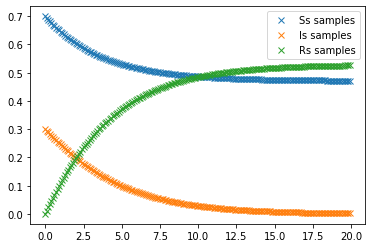

In [5]:
from src.utils import take_n_samples_regular

samples = 200

ts = take_n_samples_regular(samples, t)
Ss = take_n_samples_regular(samples, S)
Is = take_n_samples_regular(samples, I)
Rs = take_n_samples_regular(samples, R)

plt.plot(ts, Ss, 'x', label="Ss samples")
plt.plot(ts, Is, 'x', label="Is samples")
plt.plot(ts, Rs, 'x', label="Rs samples")
plt.legend()
plt.show()

La entrada de los datos al algorítmo debe ser de una forma "especial", en vez de ser un conjuno de listas como tenemos ahora mismo, debe ser una sola y única lista de entrada, y una sola y única lista de salida. Definiendo entrada como las muestras y la salida, las muestras evaluadas en el modelo 😅.

La datos de la lista de entrada son diccionarios, en donde las llaves son los nombres de las variables y los valores son los valores de esas variables en cada uno de los datos.

Los datos de la lista de salida es solamente el modelo evaluado en las muestras.

In [6]:
X_samples = [
        {"t": ts[i], "S": Ss[i], "I": Is[i], "R": Rs[i]} for i in range(len(ts))
    ]

ode = [sir_dx([Ss[i], Is[i], Rs[i]], ts[i], a, b) for i in range(len(ts))]